In [1]:
import sys
sys.path.append("../")
import os
import math
import numpy as np
import cv2
import pandas as pd
from scipy import stats
from pedrec.configs.dataset_configs import get_sim_dataset_cfg_default, get_h36m_dataset_cfg_default
from pedrec.datasets.pedrec_dataset import PedRecDataset
from pedrec.configs.pedrec_net_config import PedRecNet50Config
from pedrec.evaluations.validate import get_2d_pose_pck_results, get_3d_pose_results, get_orientation_results
from pedrec.evaluations.eval_np.eval_pose_2d import get_ref_distance_torso, get_normalized_joint_distances
from pedrec.models.constants.skeleton_pedrec import SKELETON_PEDREC_JOINTS, SKELETON_PEDREC, SKELETON_PEDREC_JOINT
from pedrec.models.constants.dataset_constants import DatasetType
from pedrec.visualizers.skeleton_visualizer import draw_skeleton
from pedrec.visualizers.skeleton_3d_visualizer import add_skeleton_3d_to_axes
from pedrec.visualizers.orientation_visualizer import add_orientation_to_axes
from pedrec.visualizers.visualization_helper_3d import draw_grid_3d, draw_origin_3d
from pedrec.models.data_structures import ImageSize
from pedrec.utils.print_helper import get_heading
from pedrec.utils.pedrec_dataset_helper import get_filter_skeleton2d, get_filter_body_orientation, \
    get_filter_skeleton3d, get_filter_bb, get_filter_head_orientation, get_filter_env
from random import randint
import matplotlib.pyplot as plt

In [2]:
def print_pck_results(gt, pred, title):
  print("####################################################################")
  print(f"############## PCK results: {title} (num samples: {gt.shape[0]})")
  print("####################################################################")
  pose2d_pck = get_2d_pose_pck_results(gt, pred)
  pose2d_pck05_per_joint = pose2d_pck.pck_05
  pose2d_pck2_per_joint = pose2d_pck.pck_2
  pose2d_pck05_mean = pose2d_pck.pck_05_mean
  pose2d_pck2_mean = pose2d_pck.pck_2_mean

  for joint, pck05, pck2 in zip(SKELETON_PEDREC_JOINTS, pose2d_pck05_per_joint, pose2d_pck2_per_joint):
    print(f"{joint.name} | PCK@0.05: {pck05:.2f} | PCK@0.2: {pck2:.2f}")

  print(f"Mean: PCK@0.05: {pose2d_pck05_mean} | PCK@0.2: {pose2d_pck2_mean}")

In [3]:
def print_pose3d_results(gt, pred, title):
  pose3d_results = get_3d_pose_results(gt, pred)
  print("########################################################")
  print(f"#################### MPJPE: {title}, Num samples: {gt.shape[0]}")
  print("########################################################")

  for joint, mpjpe, x_dist, y_dist, depth_distance in zip(SKELETON_PEDREC_JOINTS, 
                    pose3d_results.mpjpe, 
                    pose3d_results.mean_joint_x_distances,
                    pose3d_results.mean_joint_y_distances,
                    pose3d_results.mean_joint_depth_distances):
    print(f"{joint.name}: MPJPE: {mpjpe:.1f}mm | Depth distance: {depth_distance:.1f}mm | X distance: {x_dist:.1f}mm | Y distance: {y_dist:1f}mm |")
  for limb, correct_depth, correct_pos in zip(SKELETON_PEDREC, pose3d_results.pct_correct_depth_per_pair, pose3d_results.pct_correct_joint_position_per_pair):
    print(f"{SKELETON_PEDREC_JOINT(limb[0]).name}-{SKELETON_PEDREC_JOINT(limb[1]).name}: Correct Relative Position: {correct_pos*100:.2f}%, Correct Relative Depth: {correct_depth*100:.2f}%")
  print(f"Full mean: {pose3d_results.mpjpe_mean:.2f}mm | Correct Depth (Mean) {pose3d_results.pct_correct_depth_mean*100:.2f}% | Correct Joint Position (Mean): {pose3d_results.pct_correct_joint_position_mean*100:.2f}%")

In [23]:
def print_pose3d_results_latex(gt, pred, title):
  pose3d_results = get_3d_pose_results(gt, pred)
  print("########################################################")
  print(f"#################### MPJPE: {title}, Num samples: {gt.shape[0]}")
  print("########################################################")

  print("Joint & MPJPE & $\delta x$ & $\delta y$ & $\delta z$ \\\\\\midrule")
  for joint, mpjpe, x_dist, y_dist, depth_distance in zip(SKELETON_PEDREC_JOINTS, 
                    pose3d_results.mpjpe, 
                    pose3d_results.mean_joint_x_distances,
                    pose3d_results.mean_joint_y_distances,
                    pose3d_results.mean_joint_depth_distances):
    print(f"{joint.name} & ${mpjpe:.1f}$ & ${x_dist:.1f}$ & ${y_dist:.1f}$ & ${depth_distance:.1f}$ \\\\")
  for limb, correct_depth, correct_pos in zip(SKELETON_PEDREC, pose3d_results.pct_correct_depth_per_pair, pose3d_results.pct_correct_joint_position_per_pair):
    print(f"{SKELETON_PEDREC_JOINT(limb[0]).name}-{SKELETON_PEDREC_JOINT(limb[1]).name}: Correct Relative Position: {correct_pos*100:.2f}%, Correct Relative Depth: {correct_depth*100:.2f}%")
  print(f"Full mean: {pose3d_results.mpjpe_mean:.2f}mm | Correct Depth (Mean) {pose3d_results.pct_correct_depth_mean*100:.2f}% | Correct Joint Position (Mean): {pose3d_results.pct_correct_joint_position_mean*100:.2f}%")

  _, ax = plt.subplots()
  y_pos = np.arange(len(SKELETON_PEDREC_JOINTS))
  ax.bar(pose3d_results.mean_joint_x_distances, SKELETON_PEDREC_JOINTS, color="r")
  ax.set_xticks(y_pos, SKELETON_PEDREC_JOINTS)

In [5]:
def print_orientation_results(gt, pred, title):
  orientation_results = get_orientation_results(gt, pred)
  print("########################################################")
  print(f"#################### Orientation Results: {title}")
  print("########################################################")
  
  print(f"Body: Dist.Phi: {math.degrees(orientation_results.body.angle_error_phi):.2f}° | Dist.Theta: {math.degrees(orientation_results.body.angle_error_theta):.2f}° | Spherical Distance: {math.degrees(orientation_results.body.spherical_distance):.2f}°")
  print(f"Head: Dist.Phi: {math.degrees(orientation_results.head.angle_error_phi):.2f}° | Dist.Theta: {math.degrees(orientation_results.head.angle_error_theta):.2f}° | Spherical Distance: {math.degrees(orientation_results.head.spherical_distance):.2f}°")

In [6]:
def get_arrays(df: pd.DataFrame):
    filter_skeleton2d = get_filter_skeleton2d(df)
    filter_skeleton3d = get_filter_skeleton3d(df)
    filter_body_orientation = get_filter_body_orientation(df)
    filter_head_orientation = get_filter_head_orientation(df)


    skeleton2ds = df[filter_skeleton2d].to_numpy(dtype=np.float32).reshape(df.shape[0], len(SKELETON_PEDREC_JOINTS), 5)
    skeleton3ds = df[filter_skeleton3d].to_numpy(dtype=np.float32).reshape(df.shape[0], len(SKELETON_PEDREC_JOINTS), 6)
    body_orientations = df[filter_body_orientation].to_numpy(dtype=np.float32).reshape(df.shape[0], 1, 5)
    head_orientations = df[filter_head_orientation].to_numpy(dtype=np.float32).reshape(df.shape[0], 1, 5)
    all_orientations = np.concatenate((body_orientations, head_orientations), axis=1)
    orientations = np.zeros((df.shape[0], 2, 5), dtype=np.float32)
    print(all_orientations.shape)
    orientations[:, :, :6] = all_orientations
    return skeleton2ds, skeleton3ds, orientations

In [7]:
def get_gt_arrays(df: pd.DataFrame):
    filter_env = get_filter_env(df)
    filter_bb = get_filter_bb(df)
    filter_skeleton2d = get_filter_skeleton2d(df)
    filter_skeleton3d = get_filter_skeleton3d(df)
    filter_body_orientation = get_filter_body_orientation(df)
    filter_head_orientation = get_filter_head_orientation(df)

    skeleton2ds = df[filter_skeleton2d].to_numpy(dtype=np.float32).reshape(df.shape[0], len(SKELETON_PEDREC_JOINTS), 5)
    skeleton3ds = df[filter_skeleton3d].to_numpy(dtype=np.float32).reshape(df.shape[0], len(SKELETON_PEDREC_JOINTS), 6)
    body_orientations = df[filter_body_orientation].to_numpy(dtype=np.float32).reshape(df.shape[0], 1, 4)
    head_orientations = df[filter_head_orientation].to_numpy(dtype=np.float32).reshape(df.shape[0], 1, 4)
    all_orientations = np.concatenate((body_orientations, head_orientations), axis=1)
    orientations = np.zeros((df.shape[0], 2, 5), dtype=np.float32)
    print(all_orientations.shape)
    orientations[:, :, :4] = all_orientations
    orientations[:, :, 4] = 1
    bbs=df[filter_bb].to_numpy(dtype=np.float32)
    env_positions=df[filter_env].to_numpy(dtype=np.float32)
    return skeleton2ds, skeleton3ds, orientations, bbs, env_positions

In [8]:
def get_normalized_joint_dists(target, pred):
    gt_array, pred_array, visible_array = target[:, :, 0:2], pred[:, :, 0:2], target[:, :, 3]
    ref_distances = get_ref_distance_torso(gt_array)

    normalized_joint_distances = get_normalized_joint_distances(gt_array, pred_array, visible_array, ref_distances)
    #     gt_array = gt_array.copy()[ref_distances != 0]
    # pred_array = pred_array.copy()[ref_distances != 0]
    # visible_array = visible_array.copy()[ref_distances != 0]
    # ref_distances = ref_distances[ref_distances != 0]
    return normalized_joint_distances, ref_distances

In [9]:
df_results = pd.read_pickle("data/datasets/Conti01/results/C01_pred_df_experiment_pedrec_p2d3d_c_o_h36m_sim_mebow_0.pkl")
df = pd.read_pickle("data/datasets/Conti01/rt_conti_01_val.pkl")

print(len(df_results))
print(len(df))

119257
119257


In [10]:
pd.options.display.max_columns = None
pd.options.display.float_format= '{:.2f}'.format
df.head()

,dataset,dataset_type,scene_id,scene_start,scene_end,frame_nr_global,frame_nr_local,img_dir,img_id,img_type,subject_id,gender,skin_color,size,bmi,age,movement,movement_speed,is_real_img,actions,bb_center_x,bb_center_y,bb_width,bb_height,bb_score,bb_class,env_position_x,env_position_y,env_position_z,body_orientation_theta,body_orientation_phi,body_orientation_score,body_orientation_visible,head_orientation_theta,head_orientation_phi,head_orientation_score,head_orientation_visible,skeleton2d_nose_x,skeleton2d_nose_y,skeleton2d_nose_score,skeleton2d_nose_visible,skeleton2d_nose_supported,skeleton2d_left_eye_x,skeleton2d_left_eye_y,skeleton2d_left_eye_score,skeleton2d_left_eye_visible,skeleton2d_left_eye_supported,skeleton2d_right_eye_x,skeleton2d_right_eye_y,skeleton2d_right_eye_score,skeleton2d_right_eye_visible,skeleton2d_right_eye_supported,skeleton2d_left_ear_x,skeleton2d_left_ear_y,skeleton2d_left_ear_score,skeleton2d_left_ear_visible,skeleton2d_left_ear_supported,skeleton2d_right_ear_x,skeleton2d_right_ear_y,skeleton2d_right_ear_score,skeleton2d_right_ear_visible,skeleton2d_right_ear_supported,skeleton2d_left_shoulder_x,skeleton2d_left_shoulder_y,skeleton2d_left_shoulder_score,skeleton2d_left_shoulder_visible,skeleton2d_left_shoulder_supported,skeleton2d_right_shoulder_x,skeleton2d_right_shoulder_y,skeleton2d_right_shoulder_score,skeleton2d_right_shoulder_visible,skeleton2d_right_shoulder_supported,skeleton2d_left_elbow_x,skeleton2d_left_elbow_y,skeleton2d_left_elbow_score,skeleton2d_left_elbow_visible,skeleton2d_left_elbow_supported,skeleton2d_right_elbow_x,skeleton2d_right_elbow_y,skeleton2d_right_elbow_score,skeleton2d_right_elbow_visible,skeleton2d_right_elbow_supported,skeleton2d_left_wrist_x,skeleton2d_left_wrist_y,skeleton2d_left_wrist_score,skeleton2d_left_wrist_visible,skeleton2d_left_wrist_supported,skeleton2d_right_wrist_x,skeleton2d_right_wrist_y,skeleton2d_right_wrist_score,skeleton2d_right_wrist_visible,skeleton2d_right_wrist_supported,skeleton2d_left_hip_x,skeleton2d_left_hip_y,skeleton2d_left_hip_score,skeleton2d_left_hip_visible,skeleton2d_left_hip_supported,skeleton2d_right_hip_x,skeleton2d_right_hip_y,skeleton2d_right_hip_score,skeleton2d_right_hip_visible,skeleton2d_right_hip_supported,skeleton2d_left_knee_x,skeleton2d_left_knee_y,skeleton2d_left_knee_score,skeleton2d_left_knee_visible,skeleton2d_left_knee_supported,skeleton2d_right_knee_x,skeleton2d_right_knee_y,skeleton2d_right_knee_score,skeleton2d_right_knee_visible,skeleton2d_right_knee_supported,skeleton2d_left_ankle_x,skeleton2d_left_ankle_y,skeleton2d_left_ankle_score,skeleton2d_left_ankle_visible,skeleton2d_left_ankle_supported,skeleton2d_right_ankle_x,skeleton2d_right_ankle_y,skeleton2d_right_ankle_score,skeleton2d_right_ankle_visible,skeleton2d_right_ankle_supported,skeleton2d_hip_center_x,skeleton2d_hip_center_y,skeleton2d_hip_center_score,skeleton2d_hip_center_visible,skeleton2d_hip_center_supported,skeleton2d_spine_center_x,skeleton2d_spine_center_y,skeleton2d_spine_center_score,skeleton2d_spine_center_visible,skeleton2d_spine_center_supported,skeleton2d_neck_x,skeleton2d_neck_y,skeleton2d_neck_score,skeleton2d_neck_visible,skeleton2d_neck_supported,skeleton2d_head_lower_x,skeleton2d_head_lower_y,skeleton2d_head_lower_score,skeleton2d_head_lower_visible,skeleton2d_head_lower_supported,skeleton2d_head_upper_x,skeleton2d_head_upper_y,skeleton2d_head_upper_score,skeleton2d_head_upper_visible,skeleton2d_head_upper_supported,skeleton2d_left_foot_end_x,skeleton2d_left_foot_end_y,skeleton2d_left_foot_end_score,skeleton2d_left_foot_end_visible,skeleton2d_left_foot_end_supported,skeleton2d_right_foot_end_x,skeleton2d_right_foot_end_y,skeleton2d_right_foot_end_score,skeleton2d_right_foot_end_visible,skeleton2d_right_foot_end_supported,skeleton2d_left_hand_end_x,skeleton2d_left_hand_end_y,skeleton2d_left_hand_end_score,skeleton2d_left_hand_end_visible,skeleton2d_left_hand_end_supported,skeleton2d_right_hand_end_x,skeleton2d_right_hand_end_y,skeleton2d

In [11]:
env_position_xs = [col for col in df if col == "env_position_x"] 
env_position_ys = [col for col in df if col == "env_position_y"] 
env_position_zs = [col for col in df if col == "env_position_z"] 

df["distance_xz"] = np.sqrt(np.abs(df[env_position_xs].sum(axis=1)**2) + np.abs(df[env_position_zs].sum(axis=1)**2))
df_results["distance_xz"] = df["distance_xz"]
df_results["size"] = df["size"]

In [12]:
skeleton2ds, skeleton3ds, orientatio, bbs, env_positions = get_gt_arrays(df)
skeleton2ds_pred, skeleton3ds_pred, orientations_pred = get_arrays(df_results)

(119257, 2, 4)
(119257, 2, 5)


In [13]:
pck_results = print_pck_results(skeleton2ds, skeleton2ds_pred, "jo")

####################################################################
############## PCK results: jo (num samples: 119257)
####################################################################
nose | PCK@0.05: 80.10 | PCK@0.2: 98.98
left_eye | PCK@0.05: 84.66 | PCK@0.2: 99.22
right_eye | PCK@0.05: 82.75 | PCK@0.2: 99.14
left_ear | PCK@0.05: 78.06 | PCK@0.2: 99.04
right_ear | PCK@0.05: 73.67 | PCK@0.2: 98.91
left_shoulder | PCK@0.05: 60.94 | PCK@0.2: 98.55
right_shoulder | PCK@0.05: 72.45 | PCK@0.2: 98.13
left_elbow | PCK@0.05: 65.30 | PCK@0.2: 95.40
right_elbow | PCK@0.05: 58.33 | PCK@0.2: 92.24
left_wrist | PCK@0.05: 57.88 | PCK@0.2: 88.19
right_wrist | PCK@0.05: 49.25 | PCK@0.2: 80.82
left_hip | PCK@0.05: 55.56 | PCK@0.2: 95.92
right_hip | PCK@0.05: 53.59 | PCK@0.2: 95.82
left_knee | PCK@0.05: 55.69 | PCK@0.2: 91.92
right_knee | PCK@0.05: 58.17 | PCK@0.2: 91.73
left_ankle | PCK@0.05: 53.06 | PCK@0.2: 88.91
right_ankle | PCK@0.05: 50.74 | PCK@0.2: 88.99
hip_center | PCK@0.05: 63.97 | PC

Distances mean: 16199.0087890625 | min: 1690.557861328125 | max: 29863.626953125
########################################################
#################### MPJPE: Full, Num samples: 119257
########################################################
Joint & MPJPE & $\delta x$ & $\delta y$ & $\delta z$ \\\midrule
nose & $85.0$ & $29.6$ & $32.1$ & $60.1$ \\
left_eye & $82.9$ & $27.1$ & $31.3$ & $59.3$ \\
right_eye & $84.0$ & $27.8$ & $31.6$ & $60.1$ \\
left_ear & $82.3$ & $29.3$ & $27.3$ & $58.5$ \\
right_ear & $85.6$ & $30.3$ & $28.4$ & $61.1$ \\
left_shoulder & $91.1$ & $36.1$ & $28.1$ & $63.1$ \\
right_shoulder & $84.4$ & $35.3$ & $29.0$ & $56.1$ \\
left_elbow & $100.8$ & $44.1$ & $30.7$ & $68.7$ \\
right_elbow & $115.3$ & $51.1$ & $39.4$ & $75.3$ \\
left_wrist & $145.0$ & $61.2$ & $52.4$ & $96.7$ \\
right_wrist & $182.7$ & $72.7$ & $79.0$ & $114.2$ \\
left_hip & $25.9$ & $14.0$ & $6.4$ & $15.9$ \\
right_hip & $26.0$ & $14.5$ & $6.1$ & $15.8$ \\
left_knee & $105.6$ & $34.1$ & $56.1$ & 

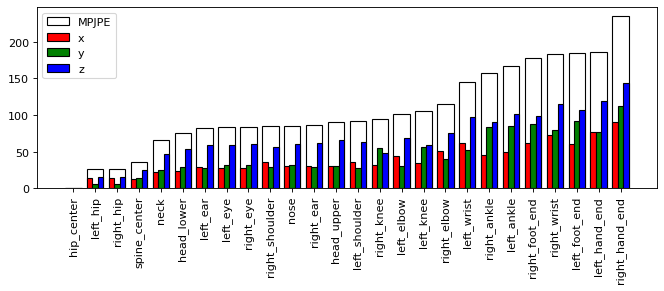

In [57]:
import tikzplotlib
def print_pose3d_results_latex(gt, pred, title):
  pose3d_results = get_3d_pose_results(gt, pred)
  print("########################################################")
  print(f"#################### MPJPE: {title}, Num samples: {gt.shape[0]}")
  print("########################################################")

  print("Joint & MPJPE & $\delta x$ & $\delta y$ & $\delta z$ \\\\\\midrule")
  for joint, mpjpe, x_dist, y_dist, depth_distance in zip(SKELETON_PEDREC_JOINTS, 
                    pose3d_results.mpjpe, 
                    pose3d_results.mean_joint_x_distances,
                    pose3d_results.mean_joint_y_distances,
                    pose3d_results.mean_joint_depth_distances):
    print(f"{joint.name} & ${mpjpe:.1f}$ & ${x_dist:.1f}$ & ${y_dist:.1f}$ & ${depth_distance:.1f}$ \\\\")
  for limb, correct_depth, correct_pos in zip(SKELETON_PEDREC, pose3d_results.pct_correct_depth_per_pair, pose3d_results.pct_correct_joint_position_per_pair):
    print(f"{SKELETON_PEDREC_JOINT(limb[0]).name}-{SKELETON_PEDREC_JOINT(limb[1]).name}: Correct Relative Position: {correct_pos*100:.2f}%, Correct Relative Depth: {correct_depth*100:.2f}%")
  print(f"Full mean: {pose3d_results.mpjpe_mean:.2f}mm | Correct Depth (Mean) {pose3d_results.pct_correct_depth_mean*100:.2f}% | Correct Joint Position (Mean): {pose3d_results.pct_correct_joint_position_mean*100:.2f}%")

  names = []
  for joint in SKELETON_PEDREC_JOINTS:
    names.append(joint.name)
  names = [x for _, x in sorted(zip(pose3d_results.mpjpe, names))]
  pose3d_results.mean_joint_x_distances = [x for _, x in sorted(zip(pose3d_results.mpjpe, pose3d_results.mean_joint_x_distances))]
  pose3d_results.mean_joint_y_distances = [x for _, x in sorted(zip(pose3d_results.mpjpe, pose3d_results.mean_joint_y_distances))]
  pose3d_results.mean_joint_depth_distances = [x for _, x in sorted(zip(pose3d_results.mpjpe, pose3d_results.mean_joint_depth_distances))]
  pose3d_results.mpjpe = sorted(pose3d_results.mpjpe)

  plt.figure(figsize=(10, 3), dpi=80)
  plt.xticks(rotation=90)
  # y_pos = np.range()
  bar_width = 0.25
  r1 = np.arange(len(names))
  r2 = [x + bar_width for x in r1]
  r3 = [x + bar_width for x in r2]

  plt.bar(r2, pose3d_results.mpjpe, width=0.75, color="white", edgecolor = 'black', label='MPJPE')
  plt.bar(r1, pose3d_results.mean_joint_x_distances, width=bar_width, color="r", edgecolor = 'black', label='$\Delta x$')
  plt.bar(r2, pose3d_results.mean_joint_y_distances, width=bar_width, color="g", edgecolor = 'black', label='$\Delta y$')
  plt.bar(r3, pose3d_results.mean_joint_depth_distances, width=bar_width, color="b", edgecolor = 'black', label='$\Delta z$')

  plt.xticks([r + bar_width for r in range(len(names))], names)
  plt.legend()
  # ax.bar(names, pose3d_results.mean_joint_y_distances, color="g")
  xmin, xmax, ymin, ymax = plt.axis()
  tikzplotlib.save("/home/dennis/Downloads/sim_c01_val_results_msjpe_barchart.tex", extra_axis_parameters={
    'width=\\textwidth',
    'title={MPJPE and joint distances per joint}',
    'enlarge y limits=0.001',
    'xticklabel style={font=\\footnotesize}',
  })

  # ax.set_xticks(y_pos, )

distances_gt = df["distance_xz"].to_numpy()
print(f"Distances mean: {np.mean(distances_gt)} | min: {np.min(distances_gt)} | max: {np.max(distances_gt)}")
print_pose3d_results_latex(skeleton3ds, skeleton3ds_pred, "Full")


(119257,)
(119257,)


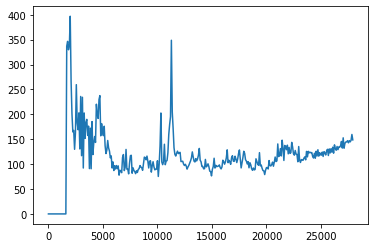

In [15]:
def get_means(distances, joint_distances, bins: int=350):
  results = []
  step_size = int(math.floor((np.max(distances)-np.min(distances)) / bins))
  steps = []
  for i in range(0, bins * step_size, step_size):
    steps.append(i)
    dists = joint_distances[(distances > i) & (distances <= i+step_size)]
    if len(dists) == 0:
      results.append(0)
      continue
    results.append(np.nanmean(dists))
  return steps, results

joint_distances = np.mean(np.linalg.norm(skeleton3ds-skeleton3ds_pred, axis=-1), axis=1)
print(distances_gt.shape)
print(joint_distances.shape)

# joint_distances, ref_distances = get_normalized_joint_dists(skeleton3ds, skeleton3ds_pred)
# joint_distances_plt = joint_distances.copy()[ref_distances != 0]
# distances_gt_plt = distances_gt.copy()[ref_distances != 0]
# joint_distances_plt = joint_distances_plt[distances_gt_plt <= 35000]
# distances_gt_plt = distances_gt_plt[distances_gt_plt <= 35000]
# joint_distance_means_plt = np.mean(joint_distances_plt, axis=1)
x, y = get_means(distances_gt, joint_distances)
fig = plt.figure()
plt.plot(x, y)
plt.show()

In [16]:
sizes = df["size"].to_numpy()
print_pose3d_results(skeleton3ds[sizes == 0], skeleton3ds_pred[sizes == 0], f"[sizes == 1]")

########################################################
#################### MPJPE: [sizes == 1], Num samples: 5193
########################################################
nose: MPJPE: 54.7mm | Depth distance: 28.1mm | X distance: 19.9mm | Y distance: 30.255737mm |
left_eye: MPJPE: 52.3mm | Depth distance: 25.8mm | X distance: 17.5mm | Y distance: 30.516191mm |
right_eye: MPJPE: 54.1mm | Depth distance: 28.1mm | X distance: 17.6mm | Y distance: 30.513462mm |
left_ear: MPJPE: 53.9mm | Depth distance: 27.2mm | X distance: 20.6mm | Y distance: 28.178858mm |
right_ear: MPJPE: 59.2mm | Depth distance: 32.9mm | X distance: 22.9mm | Y distance: 26.054117mm |
left_shoulder: MPJPE: 60.5mm | Depth distance: 35.5mm | X distance: 29.2mm | Y distance: 20.648119mm |
right_shoulder: MPJPE: 63.0mm | Depth distance: 36.7mm | X distance: 30.8mm | Y distance: 22.214735mm |
left_elbow: MPJPE: 72.4mm | Depth distance: 48.2mm | X distance: 36.8mm | Y distance: 17.195534mm |
right_elbow: MPJPE: 103.4mm | D

In [17]:
sizes = df["size"].to_numpy()
print_pose3d_results(skeleton3ds[sizes == 1], skeleton3ds_pred[sizes == 1], f"[sizes == 1]")

########################################################
#################### MPJPE: [sizes == 1], Num samples: 41907
########################################################
nose: MPJPE: 82.8mm | Depth distance: 55.5mm | X distance: 29.7mm | Y distance: 33.987774mm |
left_eye: MPJPE: 80.3mm | Depth distance: 54.3mm | X distance: 27.3mm | Y distance: 32.894638mm |
right_eye: MPJPE: 80.5mm | Depth distance: 54.8mm | X distance: 27.0mm | Y distance: 33.488949mm |
left_ear: MPJPE: 79.7mm | Depth distance: 52.8mm | X distance: 30.0mm | Y distance: 29.104570mm |
right_ear: MPJPE: 80.9mm | Depth distance: 54.4mm | X distance: 30.1mm | Y distance: 29.935263mm |
left_shoulder: MPJPE: 89.3mm | Depth distance: 59.7mm | X distance: 34.9mm | Y distance: 30.186882mm |
right_shoulder: MPJPE: 82.2mm | Depth distance: 51.9mm | X distance: 35.2mm | Y distance: 30.852064mm |
left_elbow: MPJPE: 97.6mm | Depth distance: 63.8mm | X distance: 45.1mm | Y distance: 30.044922mm |
right_elbow: MPJPE: 109.7mm | 

In [18]:
sizes = df["size"].to_numpy()
print_pose3d_results(skeleton3ds[sizes == 2], skeleton3ds_pred[sizes == 2], f"[sizes == 2]")

########################################################
#################### MPJPE: [sizes == 2], Num samples: 72157
########################################################
nose: MPJPE: 88.4mm | Depth distance: 65.1mm | X distance: 30.3mm | Y distance: 31.046391mm |
left_eye: MPJPE: 86.7mm | Depth distance: 64.7mm | X distance: 27.8mm | Y distance: 30.403709mm |
right_eye: MPJPE: 88.2mm | Depth distance: 65.6mm | X distance: 29.1mm | Y distance: 30.512163mm |
left_ear: MPJPE: 85.9mm | Depth distance: 64.1mm | X distance: 29.6mm | Y distance: 26.160299mm |
right_ear: MPJPE: 90.3mm | Depth distance: 67.1mm | X distance: 31.0mm | Y distance: 27.644732mm |
left_shoulder: MPJPE: 94.4mm | Depth distance: 67.1mm | X distance: 37.3mm | Y distance: 27.425426mm |
right_shoulder: MPJPE: 87.3mm | Depth distance: 59.9mm | X distance: 35.7mm | Y distance: 28.445162mm |
left_elbow: MPJPE: 104.7mm | Depth distance: 73.0mm | X distance: 44.0mm | Y distance: 32.137718mm |
right_elbow: MPJPE: 119.5mm |